# Variables for Hypothesis Testing 


## Introduction

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import networkx as nx
from collections import defaultdict

# Load Data
df_w1 = pd.read_csv('../Cooked/df_w1_prepared.csv')
df_w2 = pd.read_csv('../Cooked/df_w2_prepared.csv') 
df_w3 = pd.read_csv('../Cooked/df_w3_prepared.csv')

G_1 = nx.read_gml("../NA/multiplex_graph_w1.gml")
G_2 = nx.read_gml("../NA/multiplex_graph_w2.gml")
G_3 = nx.read_gml("../NA/multiplex_graph_w3.gml")

## Visualization: Political-Self-Assessment over Waves

- scale only ranged form 1 to 11 
- "0" values are missings!

In [54]:
def political_identity(df):
    dict_political_identity = {}

    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        # If self_identity is 0 or NaN, set to NaN
        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
        }
    return dict_political_identity

In [55]:
dict_polident_w1 = political_identity(df_w1)
dict_polident_w2 = political_identity(df_w2)
dict_polident_w3 = political_identity(df_w3)

In [56]:
# delta_ego_alter für Susumu, am besten mit abs() delta und nicht plus/minus 

# Build a DataFrame
df_ego = pd.DataFrame({
    'w1': {pid: data['ego'] for pid, data in dict_polident_w1.items()},
    'w2': {pid: data['ego'] for pid, data in dict_polident_w2.items()},
    'w3': {pid: data['ego'] for pid, data in dict_polident_w3.items()},
})

df_ego.index.name = 'participant_id'
df_ego = df_ego.reset_index()
df_ego_complete = df_ego.dropna()

df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True) 

df_long = df_ego_complete.melt(id_vars='participant_id', 
                      value_vars=['w1', 'w2', 'w3'],
                      var_name='wave', 
                      value_name='ego_score')

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/4294299729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True)


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/1819087568.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


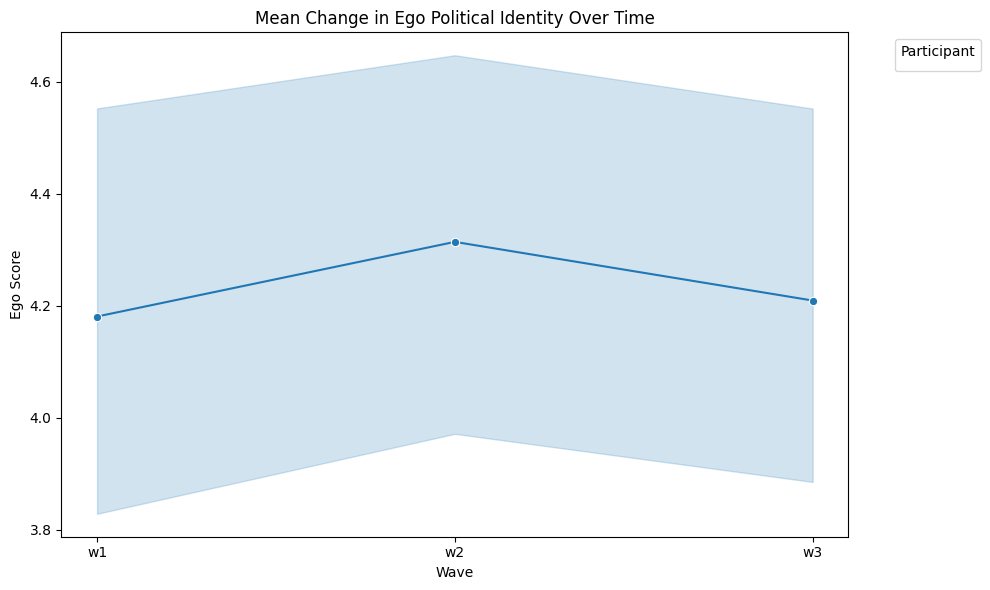

In [57]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='wave', y='ego_score', marker='o')
plt.title('Mean Change in Ego Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/1735861286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm').reversed()


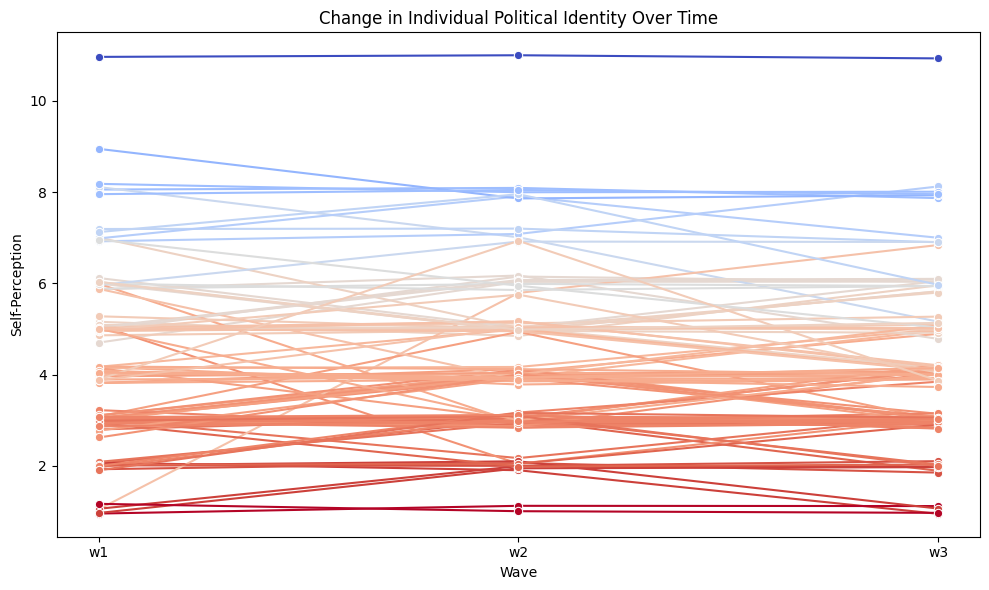

In [58]:
#### Step 1: Get average ego_score per participant!!!
participant_means = df_long.groupby('participant_id')['ego_score'].mean()

# Step 2: Normalize these scores
norm = Normalize(vmin=participant_means.min(), vmax=participant_means.max())

# Step 3: Get the colormap (blue-white-red)
cmap = get_cmap('coolwarm').reversed()

# Step 4: Map each participant to a color
participant_colors = {pid: cmap(norm(score)) for pid, score in participant_means.items()}

jitter_strength = 0.1
df_long['ego_jittered'] = df_long['ego_score'] + np.random.normal(0, jitter_strength, size=len(df_long))

# Step 5: Plot each line individually with its mapped color
plt.figure(figsize=(10, 6))
for pid, group in df_long.groupby('participant_id'):
    sns.lineplot(data=group, x='wave', y='ego_jittered', marker='o',
                 color=participant_colors[pid])

plt.title('Change in Individual Political Identity Over Time')
plt.ylabel('Self-Perception')
plt.xlabel('Wave')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()


***
## Creation: Variables for Analysis 

- Try to use the Graphs for the same task
- Keys for the dictionaries are allways the 3-Sign-Codes

In [59]:
def dictionary_polident_self_factory(G):
    # Create self-identity dictionary
    dict_polident_self = {}
    for node, value in G.nodes(data="linksrechts_self"):
        dict_polident_self[node] = value if value != 0 else np.nan
    
    return dict_polident_self

In [60]:
dict_PolIdentPercep_self_w1 = dictionary_polident_self_factory(G_1)
dict_PolIdentPercep_self_w2 = dictionary_polident_self_factory(G_2)
dict_PolIdentPercep_self_w3 = dictionary_polident_self_factory(G_3)

Filter Relation Types:
- `aquaintance` (default value)
- `study`
- `friend`
- `council`
- `politics`

Other Relation Types: (Note: filtering on these does not make sense!) 
- `sentiment`
- `leftright`

In [61]:
def dictionary_polident_others_factory(G, relation_filter="aquaintance"):

    # Create perception dictionary
    dict_polident_perception_of_others = defaultdict(dict)
    
    for u, v, d in G.edges(data=True):
        # Check if it's a leftright edge AND has the specified relation
        if d.get('type') == 'leftright':
            # Check if there's a separate edge with the specified relation type
            if G.has_edge(u, v):
                relation_data = G.get_edge_data(u, v)
                if any(edge_data.get('type') == relation_filter for edge_data in relation_data.values()):
                    if d['weight'] != 0:
                        dict_polident_perception_of_others[u][v] = d['weight']
    
    return dict_polident_perception_of_others

In [62]:
# Remember: Here the key is basically the person doing the perceiving, either of self or of others
dict_PolIdentPercep_aquaintances_w1 = dictionary_polident_others_factory(G_1, "aquaintance")
dict_PolIdentPercep_aquaintances_w2 = dictionary_polident_others_factory(G_2, "aquaintance")
dict_PolIdentPercep_aquaintances_w3 = dictionary_polident_others_factory(G_3, "aquaintance")

dict_PolIdentPercep_friends_w1 = dictionary_polident_others_factory(G_1, "friend")
dict_PolIdentPercep_friends_w2 = dictionary_polident_others_factory(G_2, "friend")
dict_PolIdentPercep_friends_w3 = dictionary_polident_others_factory(G_3, "friend")

In [63]:
def dictionary_variable_factory(G, variable_name):
    dict_grades = {}

    for key, value in G.nodes(variable_name):
        if value != -999: #filter out missing values and non-answers 
            dict_grades[key] = value
        else:
            dict_grades[key] = np.nan

    return dict_grades

In [64]:
dict_gradexpec_w1 = dictionary_variable_factory(G_1, "grade")
dict_gradexpec_w2 = dictionary_variable_factory(G_2, "grade")
dict_gradexpec_w3 = dictionary_variable_factory(G_3, "grade")

In [65]:
print("How the own identity is perceived:", dict_PolIdentPercep_self_w2["ddh"])
print("How aquaintances are perceived:", dict_PolIdentPercep_aquaintances_w2["ddh"])
print("How friends are perceived:", dict_PolIdentPercep_friends_w2["ddh"])
print("The grade expectation for oneself:", dict_gradexpec_w2["ddh"])

How the own identity is perceived: 3.0
How aquaintances are perceived: {'ceh': 3, 'kry': 7, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
How friends are perceived: {'ceh': 3, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
The grade expectation for oneself: 2.0


***
## Testing: Hypotheses and Implementation

In [84]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Assuming these are your data structures:
self_perception_w1 = dict_PolIdentPercep_self_w1  # {node: self_score}
aquaintance_perception_w1 = dict_PolIdentPercep_aquaintances_w1  # {node: {neighbor: score}}
friend_perception_w1 = dict_PolIdentPercep_friends_w1  # {node: {neighbor: score}}

self_perception_w2 = dict_PolIdentPercep_self_w2  # {node: self_score}
aquaintance_perception_w2 = dict_PolIdentPercep_aquaintances_w2  # {node: {neighbor: score}}
friend_perception_w2 = dict_PolIdentPercep_friends_w2  # {node: {neighbor: score}}

self_perception_w3 = dict_PolIdentPercep_self_w3  # {node: self_score}
aquaintance_perception_w3 = dict_PolIdentPercep_aquaintances_w3  # {node: {neighbor: score}}
friend_perception_w3 = dict_PolIdentPercep_friends_w3  # {node: {neighbor: score}}

In [96]:
def calculate_perception_metrics(self_percept, external_percept):
    """Calculate various perception difference metrics"""
    metrics = {
        'mean_diff': {},
        'median_diff': {},
        'min_diff': {},
        'max_diff': {},
        'std_diff': {}
    }
    
    for node, neighbors in external_percept.items():
        if node in self_percept:
            self_score = self_percept[node]
            if np.isnan(self_score):
                continue
                
            diffs = []
            for ext_score in neighbors.values():
                if not np.isnan(ext_score):
                    diffs.append(abs(self_score - ext_score))
            
            if diffs:
                metrics['mean_diff'][node] = np.mean(diffs)
                metrics['median_diff'][node] = np.median(diffs)
                metrics['min_diff'][node] = np.min(diffs)
                metrics['max_diff'][node] = np.max(diffs)
                metrics['std_diff'][node] = np.std(diffs)
            else:
                for metric in metrics:
                    metrics[metric][node] = np.nan
                    
    return metrics

def analyze_temporal_changes(wave_data, relationship_type):
    """Analyze changes across waves for a specific relationship type"""
    results = {
        'individual_trends': {},
        'aggregate_stats': {}
    }
    
    # Get common nodes across all waves
    common_nodes = set(wave_data[0]['mean_diff'].keys())
    for wave in wave_data[1:]:
        common_nodes.intersection_update(wave['mean_diff'].keys())
    common_nodes = [n for n in common_nodes if not any(np.isnan(wave['mean_diff'][n]) for wave in wave_data)]
    
    if not common_nodes:
        print(f"No common nodes with complete data for {relationship_type}")
        return results
    
    # Calculate individual trends
    for node in common_nodes:
        values = [wave['mean_diff'][node] for wave in wave_data]
        slope = np.polyfit([1, 2, 3], values, 1)[0]
        results['individual_trends'][node] = {
            'wave1': values[0],
            'wave2': values[1],
            'wave3': values[2],
            'slope': slope,
            'change': values[2] - values[0]
        }
    
    # Calculate aggregate statistics
    changes = [v['change'] for v in results['individual_trends'].values()]
    slopes = [v['slope'] for v in results['individual_trends'].values()]
    
    results['aggregate_stats'] = {
        'mean_change': np.mean(changes),
        'median_change': np.median(changes),
        'std_change': np.std(changes),
        'mean_slope': np.mean(slopes),
        'prop_decreasing': sum(1 for s in slopes if s < 0) / len(slopes),
        't_test_result': stats.ttest_1samp(changes, 0)
    }
    
    return results

def compare_relationship_types(friend_metrics, acquaintance_metrics):
    """Compare differences between friend and acquaintance perceptions"""
    comparison = {
        'mean_difference': {},
        'effect_size': {},
        'significance': {}
    }
    
    # Compare each wave separately
    for wave in range(3):
        friend_diffs = [v for v in friend_metrics[wave]['mean_diff'].values() if not np.isnan(v)]
        acq_diffs = [v for v in acquaintance_metrics[wave]['mean_diff'].values() if not np.isnan(v)]
        
        # Find common nodes
        common_nodes = set(friend_metrics[wave]['mean_diff'].keys()) & \
                       set(acquaintance_metrics[wave]['mean_diff'].keys())
        common_nodes = [n for n in common_nodes if not np.isnan(friend_metrics[wave]['mean_diff'][n]) and \
                       not np.isnan(acquaintance_metrics[wave]['mean_diff'][n])]
        
        if not common_nodes:
            continue
            
        paired_friend = [friend_metrics[wave]['mean_diff'][n] for n in common_nodes]
        paired_acq = [acquaintance_metrics[wave]['mean_diff'][n] for n in common_nodes]
        
        # Calculate comparison metrics
        comparison['mean_difference'][f'wave{wave+1}'] = np.mean(paired_friend) - np.mean(paired_acq)
        comparison['effect_size'][f'wave{wave+1}'] = (np.mean(paired_friend) - np.mean(paired_acq)) / \
                                                   np.sqrt((np.var(paired_friend) + np.var(paired_acq)) / 2)
        comparison['significance'][f'wave{wave+1}'] = stats.ttest_rel(paired_friend, paired_acq)
    
    return comparison

def run_full_analysis():
    # Calculate metrics for each wave and relationship type
    friend_metrics = []
    acquaintance_metrics = []
    
    for wave in range(1, 4):
        self_percept = globals()[f'self_perception_w{wave}']
        friend_percept = globals()[f'friend_perception_w{wave}']
        acq_percept = globals()[f'aquaintance_perception_w{wave}']
        
        friend_metrics.append(calculate_perception_metrics(self_percept, friend_percept))
        acquaintance_metrics.append(calculate_perception_metrics(self_percept, acq_percept))
    
    # Analyze temporal changes
    friend_temporal = analyze_temporal_changes(friend_metrics, "friends")
    acq_temporal = analyze_temporal_changes(acquaintance_metrics, "acquaintances")
    
    # Compare relationship types
    relationship_comparison = compare_relationship_types(friend_metrics, acquaintance_metrics)
    
    return {
        'friend_metrics': friend_metrics,  # Added this line
        'acquaintance_metrics': acquaintance_metrics,  # Added this line
        'friend_analysis': friend_temporal,
        'acquaintance_analysis': acq_temporal,
        'relationship_comparison': relationship_comparison
    }

results = run_full_analysis()


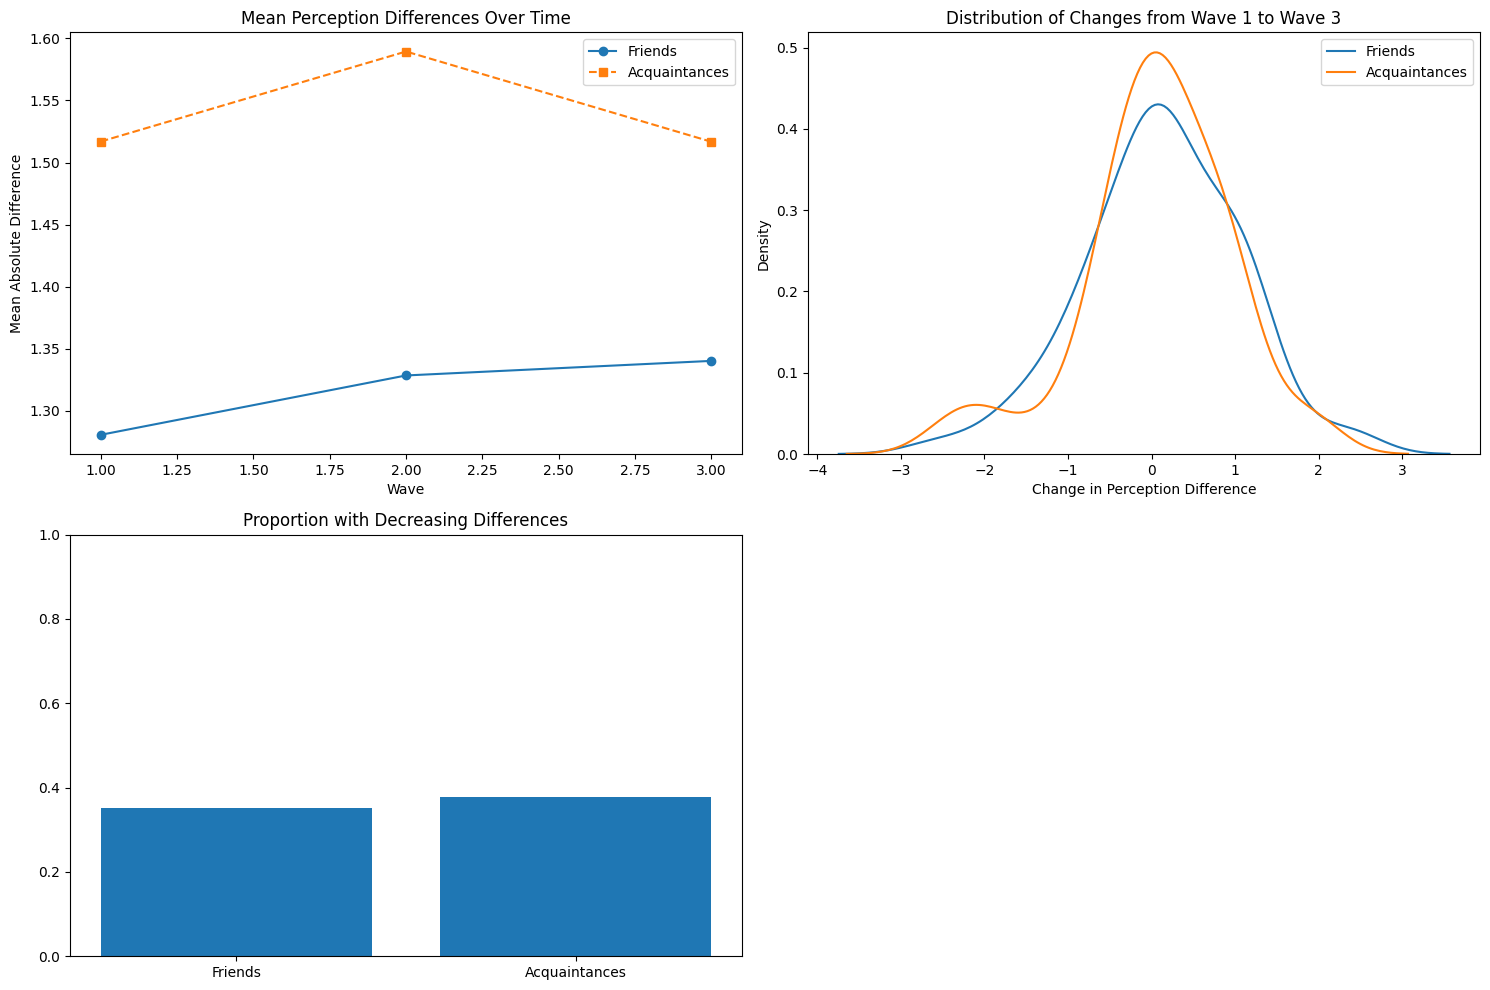

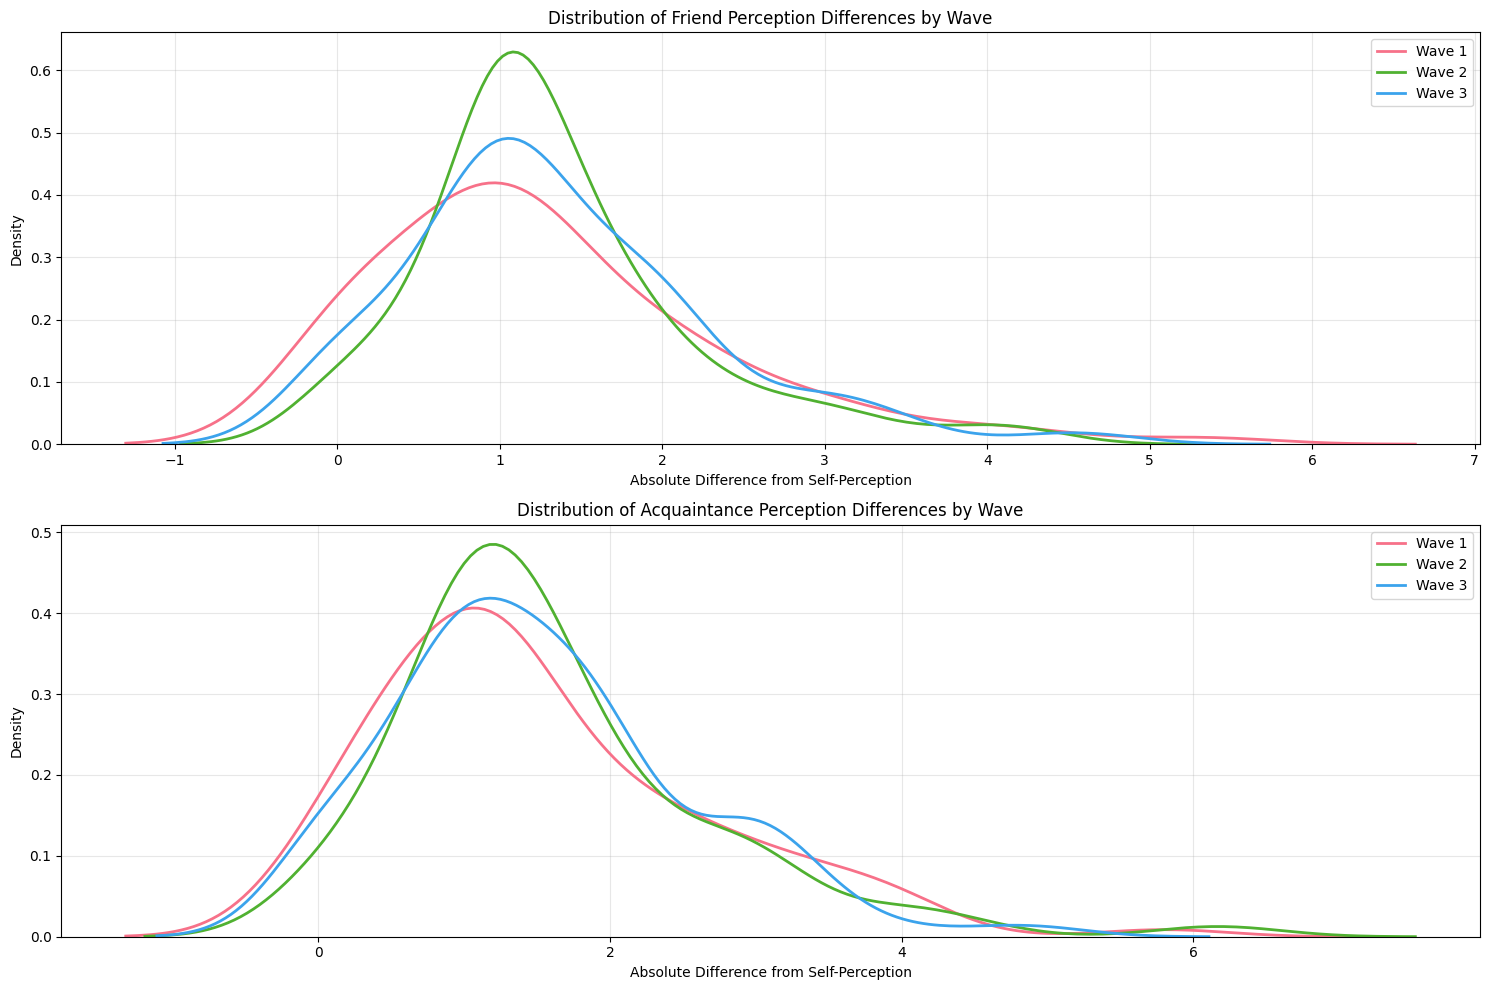

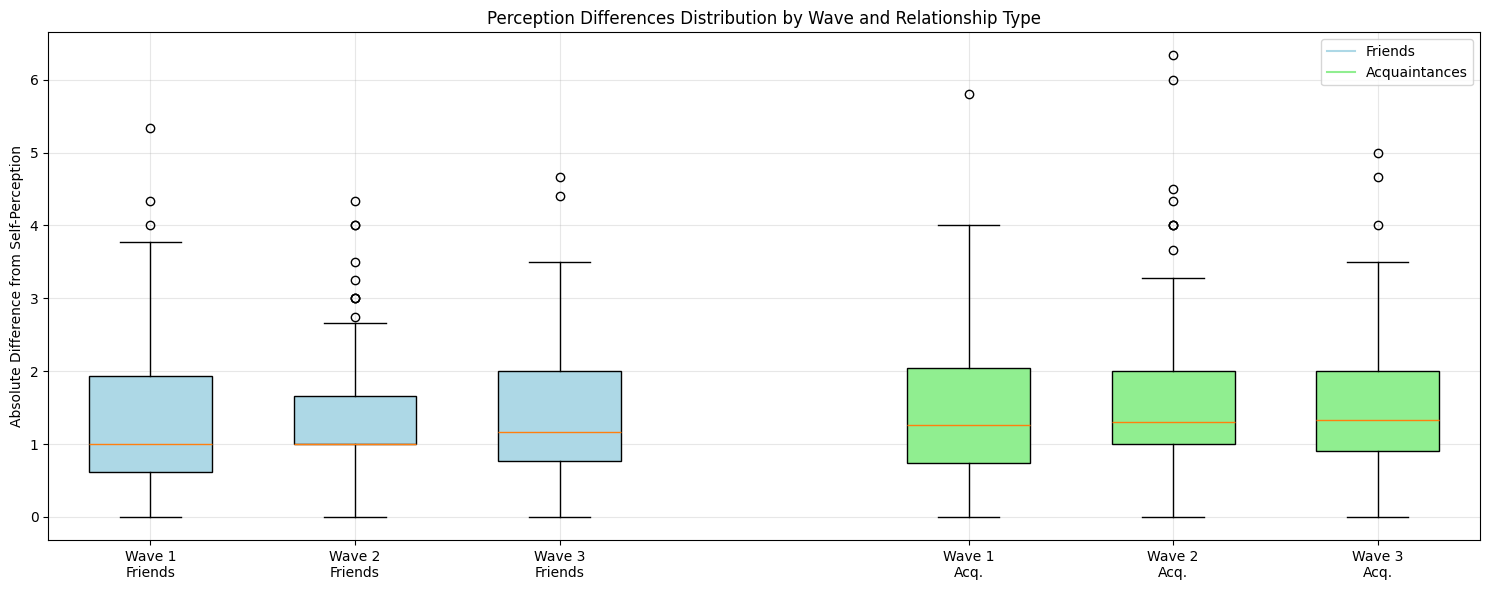

In [94]:
# Now update the plotting function to use the correct keys
def plot_results(results):
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Mean differences over time
    plt.subplot(2, 2, 1)
    friend_means = [np.nanmean(list(wave['mean_diff'].values())) for wave in results['friend_metrics']]
    acq_means = [np.nanmean(list(wave['mean_diff'].values())) for wave in results['acquaintance_metrics']]
    
    plt.plot([1, 2, 3], friend_means, 'o-', label='Friends')
    plt.plot([1, 2, 3], acq_means, 's--', label='Acquaintances')
    plt.title('Mean Perception Differences Over Time')
    plt.xlabel('Wave')
    plt.ylabel('Mean Absolute Difference')
    plt.legend()
    
    # Plot 2: Distribution of changes
    plt.subplot(2, 2, 2)
    friend_changes = [v['change'] for v in results['friend_analysis']['individual_trends'].values()]
    acq_changes = [v['change'] for v in results['acquaintance_analysis']['individual_trends'].values()]
    
    sns.kdeplot(friend_changes, label='Friends')
    sns.kdeplot(acq_changes, label='Acquaintances')
    plt.title('Distribution of Changes from Wave 1 to Wave 3')
    plt.xlabel('Change in Perception Difference')
    plt.legend()
    
    # Plot 3: Proportion with decreasing differences
    plt.subplot(2, 2, 3)
    props = [
        results['friend_analysis']['aggregate_stats']['prop_decreasing'],
        results['acquaintance_analysis']['aggregate_stats']['prop_decreasing']
    ]
    plt.bar(['Friends', 'Acquaintances'], props)
    plt.title('Proportion with Decreasing Differences')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def plot_wave_distributions(results):
    plt.figure(figsize=(15, 10))
    
    # Create a color palette
    colors = sns.color_palette("husl", 3)
    
    # Plot friend distributions by wave
    plt.subplot(2, 1, 1)
    for wave in range(3):
        wave_data = [v for v in results['friend_metrics'][wave]['mean_diff'].values() if not np.isnan(v)]
        sns.kdeplot(wave_data, color=colors[wave], label=f'Wave {wave+1}', linewidth=2)
    
    plt.title('Distribution of Friend Perception Differences by Wave')
    plt.xlabel('Absolute Difference from Self-Perception')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot acquaintance distributions by wave
    plt.subplot(2, 1, 2)
    for wave in range(3):
        wave_data = [v for v in results['acquaintance_metrics'][wave]['mean_diff'].values() if not np.isnan(v)]
        sns.kdeplot(wave_data, color=colors[wave], label=f'Wave {wave+1}', linewidth=2)
    
    plt.title('Distribution of Acquaintance Perception Differences by Wave')
    plt.xlabel('Absolute Difference from Self-Perception')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
# And we can add boxplots for another view
def plot_wave_boxplots(results):
    plt.figure(figsize=(15, 6))
    
    # Prepare data for boxplots
    friend_data = []
    acq_data = []
    for wave in range(3):
        friend_data.append([v for v in results['friend_metrics'][wave]['mean_diff'].values() if not np.isnan(v)])
        acq_data.append([v for v in results['acquaintance_metrics'][wave]['mean_diff'].values() if not np.isnan(v)])
    
    # Create positions for boxplots
    positions = np.array([1, 2, 3, 5, 6, 7])  # Leaving space between groups
    
    # Plot friend boxplots
    plt.boxplot(friend_data, positions=[1, 2, 3], widths=0.6, 
               patch_artist=True, boxprops=dict(facecolor='lightblue'))
    
    # Plot acquaintance boxplots
    plt.boxplot(acq_data, positions=[5, 6, 7], widths=0.6,
               patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    
    # Add labels and titles
    plt.xticks([1, 2, 3, 5, 6, 7], 
               ['Wave 1\nFriends', 'Wave 2\nFriends', 'Wave 3\nFriends',
                'Wave 1\nAcq.', 'Wave 2\nAcq.', 'Wave 3\nAcq.'])
    plt.title('Perception Differences Distribution by Wave and Relationship Type')
    plt.ylabel('Absolute Difference from Self-Perception')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    plt.plot([], color='lightblue', label='Friends')
    plt.plot([], color='lightgreen', label='Acquaintances')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_results(results)
plot_wave_distributions(results)
plot_wave_boxplots(results)

In [97]:
# Print key results
print("\nKey Results:")
print("Friends analysis:")
print(f"Mean change: {results['friend_analysis']['aggregate_stats']['mean_change']:.3f}")
print(f"Proportion decreasing: {results['friend_analysis']['aggregate_stats']['prop_decreasing']:.2%}")
print(f"Significance of change: p = {results['friend_analysis']['aggregate_stats']['t_test_result'].pvalue:.4f}")

print("\nAcquaintances analysis:")
print(f"Mean change: {results['acquaintance_analysis']['aggregate_stats']['mean_change']:.3f}")
print(f"Proportion decreasing: {results['acquaintance_analysis']['aggregate_stats']['prop_decreasing']:.2%}")
print(f"Significance of change: p = {results['acquaintance_analysis']['aggregate_stats']['t_test_result'].pvalue:.4f}")

print("\nRelationship comparison:")
for wave in range(1, 4):
    key = f'wave{wave}'
    if key in results['relationship_comparison']['mean_difference']:
        print(f"Wave {wave}:")
        print(f"  Mean difference: {results['relationship_comparison']['mean_difference'][key]:.3f}")
        print(f"  Effect size: {results['relationship_comparison']['effect_size'][key]:.3f}")
        print(f"  Significance: p = {results['relationship_comparison']['significance'][key].pvalue:.4f}")


Key Results:
Friends analysis:
Mean change: 0.122
Proportion decreasing: 35.06%
Significance of change: p = 0.2506

Acquaintances analysis:
Mean change: 0.068
Proportion decreasing: 37.76%
Significance of change: p = 0.4560

Relationship comparison:
Wave 1:
  Mean difference: -0.249
  Effect size: -0.232
  Significance: p = 0.0000
Wave 2:
  Mean difference: -0.141
  Effect size: -0.166
  Significance: p = 0.0049
Wave 3:
  Mean difference: -0.143
  Effect size: -0.157
  Significance: p = 0.0028
